# West Nile Virus prediction

### Import libraries

In [68]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.utils import resample

from sklearn.cluster import DBSCAN

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

from keras.models import Sequential
from keras.layers import Dense

sns.set_style("darkgrid")

### Load Data

In [69]:
wx = pd.read_csv("data/weather.csv")
spray = pd.read_csv("data/spray.csv")
train = pd.read_csv("data/train.csv")
ss = pd.read_csv("data/sampleSubmission.csv")

### Exploratory Data Analysis, Cleaning

In [70]:
train['Date'] = pd.to_datetime(train['Date'])

In [71]:
spray['Date'] = pd.to_datetime(spray['Date'])
spray['am_pm'] = spray['Time'].apply(lambda x: str(x).split()[-1])
spray['Time'] = spray['Time'].apply(lambda x: str(x).split()[0])

# spray['Time'] = pd.to_datetime(spray['Time'], format = '%H:%M:%S')

In [72]:
#converting Weather columns to datetime
wx['Date'] = pd.to_datetime(wx['Date'])

In [73]:
wx_sm = wx[['Date', 'Station', 'Tavg']].copy()

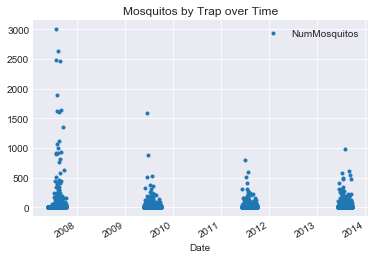

In [74]:
#plotted mosquitos by trap by date
train[['Date', 'Trap', 'NumMosquitos']].groupby(by = ['Date','Trap'])['Date','Trap','NumMosquitos'] \
    .sum().reset_index().sort_values('NumMosquitos', ascending = False).set_index('Date').plot(style = '.')
    
plt.title('Mosquitos by Trap over Time');

### Feature Engineering

#### Find closest Wx station

In [75]:
from haversine import haversine

#### It looks like a trap moved, or has two different locations:

In [76]:
len(train.Latitude.unique())

138

In [77]:
len(train.Trap.unique())

136

#### Explore trap locations in the context of nearest weather station

In [78]:
traps = train[['Trap', 'Latitude', 'Longitude']].drop_duplicates(['Trap']).reset_index(drop=True)

In [79]:
locations = []
for i in range(len(traps)):
    locations.append((traps['Latitude'][i], traps['Longitude'][i]))

In [80]:
ll = pd.Series(locations)
traps['Location'] = ll.values

In [81]:
traps.head()

,Trap,Latitude,Longitude,Location
0,T002,41.954690,-87.800991,"(41.95469, -87.800991)"
1,T007,41.994991,-87.769279,"(41.994991, -87.769279)"
2,T015,41.974089,-87.824812,"(41.974089, -87.824812)"
3,T045,41.921600,-87.666455,"(41.9216, -87.666455)"
4,T046,41.891118,-87.654491,"(41.891118, -87.654491)"


In [82]:
# Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
st1 = (41.995, -87.933)

# Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level
st2 = (41.786, -87.752)

In [83]:
my_list = []
for location in locations:
    if haversine(st2, location) < haversine(st1, location):
        my_list.append(2)
    else:
        my_list.append(1)

print('# of st1:', my_list.count(1))
print('# of st2:', my_list.count(2))

# of st1: 39
# of st2: 97


In [84]:
import math

#initialize variables
radius = 6371 #km

# custom Great Circle Distance (haversine) function
def GCD(lat1,lon1,lat2,lon2):
    #code goes here
    sin1 = math.sin(math.radians(lat1))
    sin2 = math.sin(math.radians(lat2))
    cos1 = math.cos(math.radians(lat1))
    cos2 = math.cos(math.radians(lat2))
    dellon = math.cos(abs(math.radians(lon2-lon1)))
    
    delsigma = math.acos(sin1*sin2 + cos1*cos2*dellon)

    d = radius*delsigma
    return d

In [85]:
# Wx station 1 coordinates
lat1 = 41.995
lat2 = 41.786

# Wx station 2 coordinates
lon1 = -87.933
lon2 = -87.752

In [86]:
# calculate distance between trap and each Wx station
# assign trap to appropriate station (closest)

train['Station'] = 1

for i in range(train.shape[0]):
    if GCD(lat1, lon1, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']) > GCD(lat2, lon2, train.loc[i, 'Latitude'], train.loc[i, 'Longitude']):
        train.loc[i,'Station'] = 2

In [87]:
# verify results
train['Station'].unique()

array([1, 2])

### Merge Wx data on to train data

In [88]:
train = train.merge(wx_sm, how = 'left', on = ['Date','Station'])

In [89]:
# verify merge on Wx stations
train.groupby(by ='Station')['Station'].count()

Station
1    3298
2    7208
Name: Station, dtype: int64

In [90]:
# drop variables not needed for predicting WNV
train.drop(columns=['AddressAccuracy','AddressNumberAndStreet', 'Block', 'Street', 
                    'Address', 'Station', 'Latitude', 'Longitude'], inplace=True)

### Get dummies for unique mosquito species

In [91]:
# split out dual mosqito species lines into separate columns
train['Species'] = train['Species'].apply(lambda x: x.split('/'))

train['Species1'] = train['Species'].apply(lambda x: 'CULEX ' + x[1] if len(x) == 2 else 'NaN')
train['Species0'] = train['Species'].apply(lambda x: x[0])

In [92]:
# get dummies for mosquito species
train = pd.get_dummies(train, prefix = 'Species', columns = ['Species0'])

In [93]:
# add in the RESTUANS species from the split column
for i in range(train.shape[0]):
    if train.loc[i, 'Species1'] == 'CULEX RESTUANS':
        train.loc[i,'Species_CULEX RESTUANS'] = 1

In [94]:
# drop the species column
train.drop(columns = ['Species','Species1'], inplace = True)

In [95]:
# separate week, month, and year
train['Week'] = train['Date'].dt.week
train['Month'] = train['Date'].dt.month
train['Year'] = train['Date'].dt.year

# drop date column
train.drop(columns = 'Date', inplace = True)

#get dummies
train = pd.get_dummies(train, columns = ['Week', 'Month', 'Year', 'Trap'])

### Clustering spray data
##### Assign traps as sprayed or not sprayed

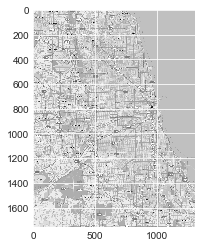

In [96]:
mapdata = np.loadtxt("data/mapdata_copyright_openstreetmap_contributors.txt")
plt.imshow(mapdata, cmap = plt.get_cmap('gray'))
# plt.savefig('map.png')

In [97]:
spray.Date.unique()

array(['2011-08-29T00:00:00.000000000', '2011-09-07T00:00:00.000000000',
       '2013-07-17T00:00:00.000000000', '2013-07-25T00:00:00.000000000',
       '2013-08-08T00:00:00.000000000', '2013-08-15T00:00:00.000000000',
       '2013-08-16T00:00:00.000000000', '2013-08-22T00:00:00.000000000',
       '2013-08-29T00:00:00.000000000', '2013-09-05T00:00:00.000000000'], dtype='datetime64[ns]')

In [98]:
# create column for sprayed (values: [1, 0]) if trap has been sprayed yet that year

In [99]:
# plt.scatter(train.Longitude, train.Latitude, color='b')
# plt.scatter(spray.Longitude, spray.Latitude, color='red')


In [100]:
# import hdbscan

In [101]:
# clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
# clusterer.fit

# Modeling

In [102]:
# Baseline accuracy is 94.76%
format(1 - train['WnvPresent'].sum()/train.shape[0], '.5f')

'0.94755'

In [103]:
# independent variables/ features to predict presence of WNV
X = train.drop(columns = 'WnvPresent')
# target
y = train['WnvPresent']

In [130]:
# split training and test data (70-30) 
# random state=42 for reproducability
# stratify on WNV to balance classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, 
                                                    random_state=42, stratify=train['WnvPresent'])

In [131]:
# standardizing data to normalize with a mean of 0 and a stdDev of 1
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [137]:
# create neural network
model = Sequential()

input_units = X_train.shape[1]
hidden_units = round(input_units)

model.add(Dense(hidden_units, 
                input_dim = input_units, 
                activation = 'relu'))

model.add(Dense(1, activation = 'sigmoid'))

model.add(Dense(1, activation = 'relu'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['binary_accuracy'])

In [133]:
train.head()

,NumMosquitos,WnvPresent,Tavg,Species_CULEX ERRATICUS,Species_CULEX PIPIENS,Species_CULEX RESTUANS,Species_CULEX SALINARIUS,Species_CULEX TARSALIS,Species_CULEX TERRITANS,Week_22,...,Trap_T230,Trap_T231,Trap_T232,Trap_T233,Trap_T235,Trap_T236,Trap_T237,Trap_T238,Trap_T900,Trap_T903
0,1,0,74,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,0,74,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,0,74,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,0,74,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,4,0,74,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [134]:
history = model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs=10, 
                   batch_size=None, 
                   verbose=1)

Train on 7354 samples, validate on 3152 samples
Epoch 1/10
7354/7354 [==============================] - 1s 89us/step - loss: 1.0708 - binary_accuracy: 0.9249 - val_loss: 0.9260 - val_binary_accuracy: 0.9423
Epoch 2/10
7354/7354 [==============================] - 0s 49us/step - loss: 0.8939 - binary_accuracy: 0.9441 - val_loss: 0.9095 - val_binary_accuracy: 0.9435
Epoch 3/10
7354/7354 [==============================] - 0s 47us/step - loss: 0.8893 - binary_accuracy: 0.9447 - val_loss: 0.9095 - val_binary_accuracy: 0.9435
Epoch 4/10
7354/7354 [==============================] - 0s 51us/step - loss: 0.8893 - binary_accuracy: 0.9447 - val_loss: 0.9095 - val_binary_accuracy: 0.9435
Epoch 5/10
7354/7354 [==============================] - 0s 50us/step - loss: 0.8893 - binary_accuracy: 0.9447 - val_loss: 0.9095 - val_binary_accuracy: 0.9435
Epoch 6/10
7354/7354 [==============================] - 0s 49us/step - loss: 0.8893 - binary_accuracy: 0.9447 - val_loss: 0.9095 - val_binary_accuracy: 0.943

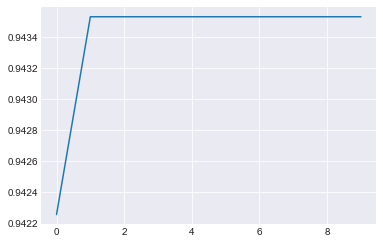

In [135]:
plt.plot(history.history['val_binary_accuracy'])

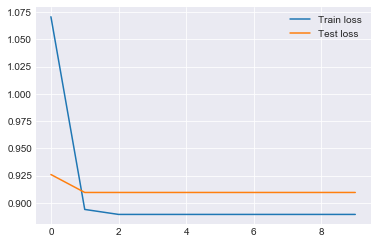

In [136]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train loss')
plt.plot(test_loss, label = 'Test loss')
plt.legend()

In [123]:
# confusion matrix, roc
fpr, tpr, _ = roc_curve(y_test, model.predict(X_test))
roc_auc = auc(fpr, tpr)
roc_auc

0.49899564780716438

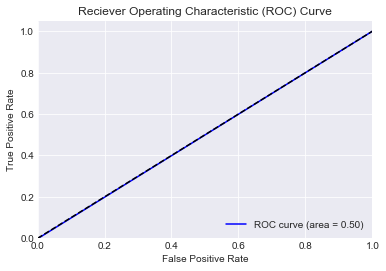

In [124]:
#plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, color = 'blue')
plt.plot([0, 1], [0,1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Reciever Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [125]:
# XGBoost model
model = xgb.XGBClassifier(seed=42)

eval_set = [(X_train, y_train), (X_test, y_test)]
scores = cross_val_score(xgb.XGBClassifier(), X_train, y_train, cv=5, n_jobs =-1)

In [126]:
model.fit(X_train, y_train, eval_metric="auc", eval_set=eval_set, verbose=True)

[0]	validation_0-auc:0.804682	validation_1-auc:0.800029
[1]	validation_0-auc:0.806273	validation_1-auc:0.798228
[2]	validation_0-auc:0.823363	validation_1-auc:0.813329
[3]	validation_0-auc:0.823285	validation_1-auc:0.813329
[4]	validation_0-auc:0.834653	validation_1-auc:0.81855
[5]	validation_0-auc:0.836226	validation_1-auc:0.820662
[6]	validation_0-auc:0.836836	validation_1-auc:0.820865
[7]	validation_0-auc:0.835985	validation_1-auc:0.820372
[8]	validation_0-auc:0.836334	validation_1-auc:0.820982
[9]	validation_0-auc:0.836192	validation_1-auc:0.82069
[10]	validation_0-auc:0.83625	validation_1-auc:0.820822
[11]	validation_0-auc:0.851161	validation_1-auc:0.835872
[12]	validation_0-auc:0.856805	validation_1-auc:0.838992
[13]	validation_0-auc:0.85728	validation_1-auc:0.838293
[14]	validation_0-auc:0.856352	validation_1-auc:0.837552
[15]	validation_0-auc:0.856965	validation_1-auc:0.838297
[16]	validation_0-auc:0.859599	validation_1-auc:0.839309
[17]	validation_0-auc:0.860208	validation_1-a

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [127]:
model.score(X_test, y_test)

0.94860406091370564